In [50]:
dataset = "zhao"
metric = "auroc_scores"
naive_models = ["InDegreeTargetSorter", "OutDegreeSourceSorter", "CorrelationDecoder", "HarmonicDegreeSorter"]
models_selected = {
    "GATv2Conv + MLPDecoder": {'mplayer': 'GATv2Conv', 'decoder': 'MLPDecoder', 'encoder': 'GNNEncoder'}, 
    "GCNConv + MLPDecoder": {'mplayer': 'GCNConv', 'decoder': 'MLPDecoder', 'encoder': 'GNNEncoder'}, 
    "GCNConv + InnerProductDecoder": {'mplayer': 'GCNConv', 'decoder': 'InnerProductDecoder', 'encoder': 'GNNEncoder'},
    "GCNConv only": {'mplayer': 'GCNConv', 'decoder': 'MLPDecoder', 'encoder': 'GNNGraphOnlyEncoder'},
}

In [51]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import wandb
api = wandb.Api()

In [52]:
def fetch_runs(run_ids):
    out = {}
    for run_id in run_ids:
        try:
            run = api.run(f"scialdonelab/GRN_inference/{run_id}")
            cfg = run.config
            tenfold = api.runs("scialdonelab/GRN_inference", {"group": f"10fold_run_{run.id}"})
            out[run_id] = {
                "encoder": "GNNEncoder" if cfg.get("encoder", "") == "GAE_Encoder" else cfg.get("encoder", ""),
                "mplayer": cfg.get("mplayer", ""),
                "decoder": cfg.get("decoder", ""),
                "sampling": cfg.get("negative_sampling", ""),
                "val_scores": [r.summary.get("val_average_precision_score", 0) for r in tenfold],
                "ap_scores": [r.summary.get("average_precision_score", 0) for r in tenfold],
                "auroc_scores": [r.summary.get("roc_auc_score", 0) for r in tenfold],
                "top_run_id": run.id,
            }
        except Exception as e:
            print(f"Error retrieving run {run_id}: {e}")
    return out

run_ids = [
    "df54ey1e","njl162p1","00mdnkwn","53spb369","zgy49z99","gzxy5164",
    "4rvc133w","w64aad0a","91111gr1","ypm5rzod","s4khp2rv","38qxu1ve",
]

sweeps_runs = fetch_runs(run_ids)
for run_id in run_ids:
    d = sweeps_runs.get(run_id, {})
    scores = d.get("auroc_scores", [])
    s = d.get("sampling", "")
    dec = d.get("decoder", "")
    mpl = d.get("mplayer", "")
    enc = d.get("encoder", "")
    print(f"Run ID: {run_id}, Model: {dec}_{mpl}_{enc}_{s}, Number of scores: {len(scores)}, Mean: {np.mean(scores):.4f}")


Run ID: df54ey1e, Model: InnerProductDecoder_GCNConv_GNNEncoder_degree_aware, Number of scores: 10, Mean: 0.5050
Run ID: njl162p1, Model: InnerProductDecoder_GCNConv_GNNEncoder_random, Number of scores: 10, Mean: 0.9964
Run ID: 00mdnkwn, Model: InnerProductDecoder_GCNConv_GNNEncoder_structured_tail, Number of scores: 10, Mean: 0.5644
Run ID: 53spb369, Model: MLPDecoder_GATv2Conv_GNNEncoder_degree_aware, Number of scores: 10, Mean: 0.5059
Run ID: zgy49z99, Model: MLPDecoder_GATv2Conv_GNNEncoder_random, Number of scores: 10, Mean: 0.9839
Run ID: gzxy5164, Model: MLPDecoder_GATv2Conv_GNNEncoder_structured_tail, Number of scores: 10, Mean: 0.5886
Run ID: 4rvc133w, Model: MLPDecoder_GCNConv_GNNEncoder_degree_aware, Number of scores: 10, Mean: 0.5031
Run ID: w64aad0a, Model: MLPDecoder_GCNConv_GNNEncoder_random, Number of scores: 10, Mean: 0.9992
Run ID: 91111gr1, Model: MLPDecoder_GCNConv_GNNEncoder_structured_tail, Number of scores: 10, Mean: 0.5921
Run ID: ypm5rzod, Model: MLPDecoder_GCNC

In [53]:
naive_run_ids = [
    "ivk0ydr6","9uqudp73","ulqvoni1","kyuvtba8","irpza8dz","3kiybyyz",
    "9653b013","hnuaaieq","yn3onvws","cf0g5o3z","4p6z3ofx","n5r24sba",
]

naive_runs = fetch_runs(naive_run_ids)
filtered_naive_runs = {
    k: {
        **v,
        "val_scores": [s for s in v.get("val_scores", []) if s != 0],
        "ap_scores": [s for s in v.get("ap_scores", []) if s != 0],
        "auroc_scores": [s for s in v.get("auroc_scores", []) if s != 0],
    }
    for k, v in naive_runs.items()
}

for run_id in naive_run_ids:
    d = filtered_naive_runs.get(run_id, {})
    scores = d.get("auroc_scores", [])
    s = d.get("sampling", "")
    dec = d.get("decoder", "")
    mean_val = np.mean(scores) if len(scores) > 0 else float("nan")
    print(f"Naive Model: {run_id}, Model: {dec}_{s}, Number of scores: {len(scores)}, Mean: {mean_val:.4f}")

Naive Model: ivk0ydr6, Model: InDegreeTargetSorter_random, Number of scores: 10, Mean: 0.5869
Naive Model: 9uqudp73, Model: InDegreeTargetSorter_structured_tail, Number of scores: 10, Mean: 0.6557
Naive Model: ulqvoni1, Model: InDegreeTargetSorter_degree_aware, Number of scores: 10, Mean: 0.5048
Naive Model: kyuvtba8, Model: OutDegreeSourceSorter_random, Number of scores: 10, Mean: 0.9993
Naive Model: irpza8dz, Model: OutDegreeSourceSorter_structured_tail, Number of scores: 10, Mean: 0.5000
Naive Model: 3kiybyyz, Model: OutDegreeSourceSorter_degree_aware, Number of scores: 10, Mean: 0.5000
Naive Model: 9653b013, Model: CorrelationDecoder_random, Number of scores: 10, Mean: 0.5459
Naive Model: hnuaaieq, Model: CorrelationDecoder_structured_tail, Number of scores: 10, Mean: 0.5381
Naive Model: yn3onvws, Model: CorrelationDecoder_degree_aware, Number of scores: 10, Mean: 0.5044
Naive Model: cf0g5o3z, Model: HarmonicDegreeSorter_random, Number of scores: 10, Mean: 0.9930
Naive Model: 4p6z3

In [54]:
runs = {**filtered_naive_runs, **sweeps_runs}
df = pd.DataFrame.from_dict(runs, orient="index")
df["mplayer"] = df.get("mplayer", "").fillna("")
df["decoder"] = df.get("decoder", "").fillna("")
df["encoder"] = df.get("encoder", "").fillna("")
df["model_key"] = df.apply(lambda r: " + ".join([x for x in [r["mplayer"], r["decoder"], r["encoder"]] if x != ""]), axis=1)
models_to_plot = naive_models + list(models_selected.keys())
label_to_model_key = {d: d for d in naive_models}
for lbl, spec in models_selected.items():
    label_to_model_key[lbl] = " + ".join([spec["mplayer"], spec["decoder"], spec["encoder"]])
label_abbrev = {
    "GCNConv + MLPDecoder": "GCN + MLP",
    "GCNConv only": "Graph only (GCN)",
    "GATv2Conv + MLPDecoder": "GAT + MLP",
    "GCNConv + InnerProductDecoder": "GCN + InnerProduct",
    "CorrelationDecoder": "Feature correlation",
    "OutDegreeSourceSorter": "OutDegree Sorter",
    "InDegreeTargetSorter": "InDegree Sorter",
    "HarmonicDegreeSorter": "HarmonicDegree Sorter",
    "Feature correlation": "Feature correlation",
}
for d in naive_models:
    if d not in label_abbrev:
        if d.lower().startswith("correlation"):
            label_abbrev[d] = "Feature correlation"
        elif "OutDegree" in d:
            label_abbrev[d] = "OutDegree Sorter"
        elif "InDegree" in d:
            label_abbrev[d] = "InDegree Sorter"
        elif "Harmonic" in d and "Inverted" not in d:
            label_abbrev[d] = "HarmonicDegree Sorter"
        else:
            label_abbrev[d] = d
model_colors_abbrev = {
    "InDegree Sorter": "#e41a1c",
    "OutDegree Sorter": "#377eb8",
    "Feature correlation": "#4daf4a",
    "HarmonicDegree Sorter": "#984ea3",
    "InvertedHarmonicDegreeSorter": "#ffff33",
    "GAT + MLP": "#ff7f00",
    "GCN + MLP": "#a65628",
    "GCN + InnerProduct": "#f781bf",
    "Graph only (GCN)": "#000000",
}
desired_abbrev_order = [
    "GCN + MLP",
    "GAT + MLP",
    "GCN + InnerProduct",
    "Feature correlation",
    "Graph only (GCN)",
    "HarmonicDegree Sorter",
    "OutDegree Sorter",
    "InDegree Sorter",
]
unique_sampling = sorted(df["sampling"].unique(), key=lambda x: (x != "structured_tail", x))

def row_label(row):
    if row["decoder"] in naive_models:
        return row["decoder"]
    if row["mplayer"] == "GCNConv" and row["decoder"] == "MLPDecoder" and row["encoder"] == "GNNGraphOnlyEncoder":
        return "GCNConv only"
    if row["mplayer"] == "GCNConv" and row["decoder"] == "MLPDecoder" and row["encoder"] != "GNNGraphOnlyEncoder":
        return "GCNConv + MLPDecoder"
    if row["mplayer"] == "GATv2Conv" and row["decoder"] == "MLPDecoder":
        return "GATv2Conv + MLPDecoder"
    if row["mplayer"] == "GCNConv" and row["decoder"] == "InnerProductDecoder":
        return "GCNConv + InnerProductDecoder"
    return None

records = []
for _, r in df.iterrows():
    lbl = row_label(r)
    if not lbl:
        continue
    abbrev = label_abbrev.get(lbl, lbl)
    model_text = label_to_model_key.get(lbl, r["model_key"])
    for s in r[metric]:
        records.append({"sampling": r["sampling"], "model": model_text, "score": s, "abbrev": abbrev})
long_df = pd.DataFrame.from_records(records)

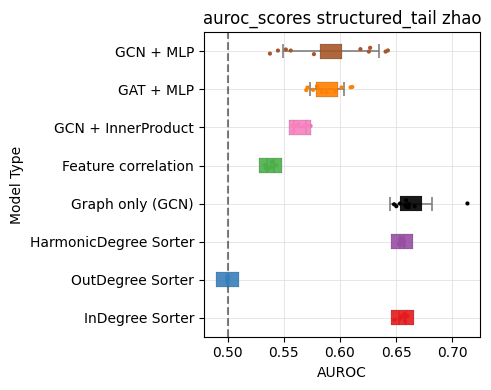

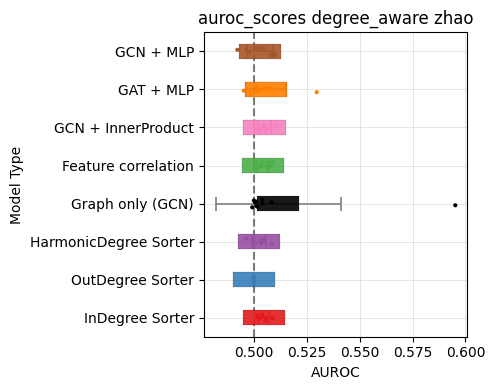

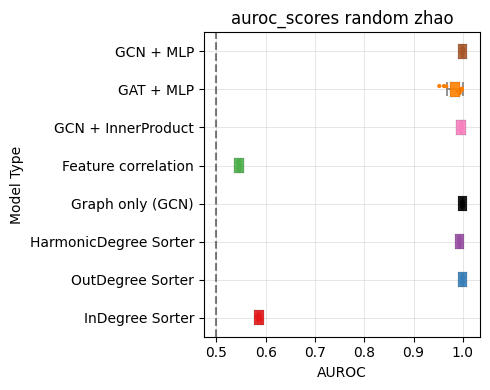

In [55]:
for sampling in unique_sampling:
    fig, ax = plt.subplots(figsize=(5, 4))
    data_sub = long_df[long_df["sampling"] == sampling].copy()
    present = data_sub["abbrev"].unique().tolist()
    abbrev_order = [a for a in desired_abbrev_order if a in present]
    abbrev_palette = {a: model_colors_abbrev.get(a, "#cccccc") for a in abbrev_order}
    mean_rect_width = 0.02
    mean_rect_height = 0.38
    for j, a in enumerate(abbrev_order):
        vals = data_sub[data_sub["abbrev"] == a]["score"]
        m = vals.mean()
        s = vals.std()
        if pd.isna(m):
            continue
        c = abbrev_palette.get(a, "#cccccc")
        if not pd.isna(s):
            ax.errorbar(x=m, y=j, xerr=s, fmt="none", ecolor="grey", elinewidth=1.2, capsize=5, capthick=1.2, zorder=1)
        rect = mpatches.Rectangle((m - mean_rect_width / 2, j - mean_rect_height / 2), width=mean_rect_width, height=mean_rect_height, facecolor=c, edgecolor="black", zorder=4, alpha=0.9, linewidth=0.1)
        ax.add_patch(rect)
    data_sub["abbrev"] = pd.Categorical(data_sub["abbrev"], categories=abbrev_order, ordered=True)
    sns.stripplot(data=data_sub, y="abbrev", x="score", hue="abbrev", order=abbrev_order, palette=abbrev_palette, size=3, dodge=False, ax=ax)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(f"{metric} {sampling} {dataset}")
    ax.set_ylabel("Model Type")
    ax.set_xlabel("AUROC")
    yticks = np.arange(len(abbrev_order))
    ax.set_yticks(yticks)
    ax.set_yticklabels(abbrev_order, rotation=0, ha="right")
    ax.xaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
    if metric == "auroc_scores":
        ax.axvline(x=0.5, color="black", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"outputs/sina_plot_{sampling}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

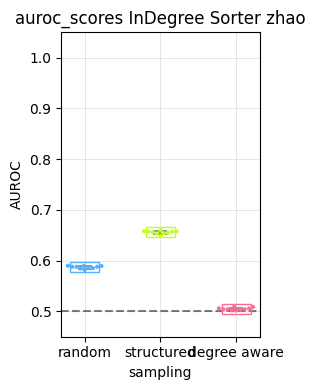

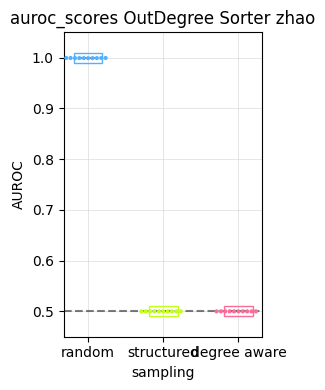

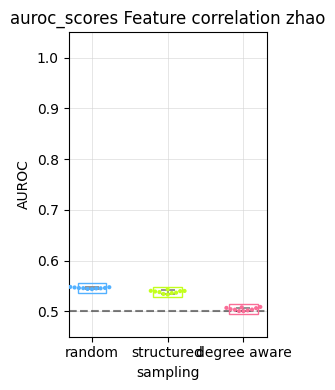

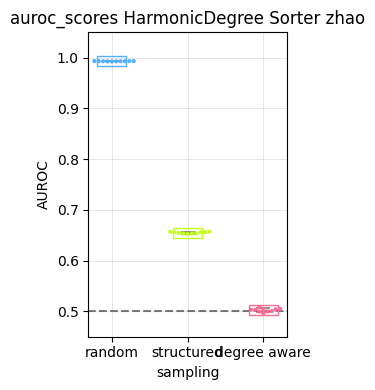

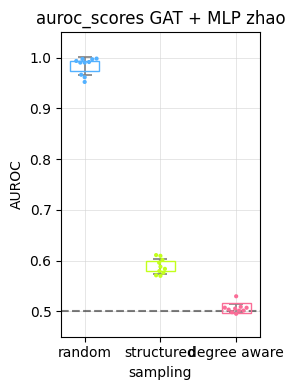

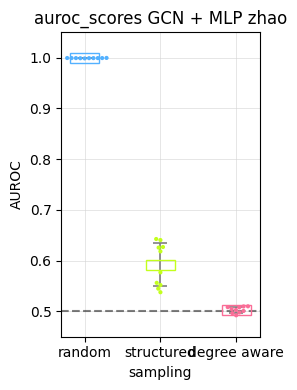

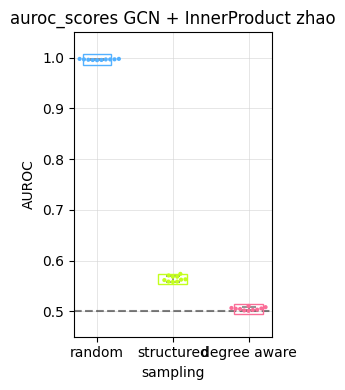

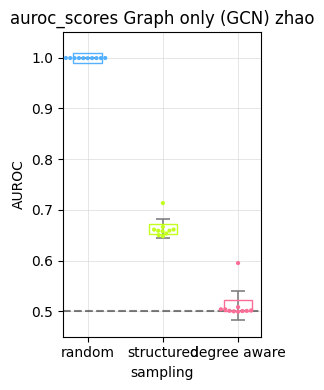

In [56]:
sampling_order = ["random", "structured_tail", "degree_aware"]
colors_map = {"structured_tail": "#C3FF1D", "random": "#53B1FF", "degree_aware": "#FA6D97"}
labels = models_to_plot
for label in labels:
    model_key = label_to_model_key[label]
    abbrev = label_abbrev.get(label, label)
    data_sub = long_df[long_df["model"] == model_key].copy()
    if data_sub.empty:
        continue
    data_sub["sampling"] = pd.Categorical(data_sub["sampling"], categories=sampling_order, ordered=True)
    fig, ax = plt.subplots(figsize=(3, 4))
    sns.swarmplot(data=data_sub, x="sampling", y="score", hue="sampling", order=sampling_order, palette=colors_map, size=3, dodge=False, legend=False, ax=ax)
    mean_rect_width = 0.38
    mean_rect_height = 0.02
    for i, s in enumerate(sampling_order):
        vals = data_sub.loc[data_sub["sampling"] == s, "score"]
        if len(vals) == 0:
            continue
        mean_val = float(vals.mean())
        std_val = float(vals.std()) if len(vals) > 1 else np.nan
        if not np.isnan(std_val):
            ax.errorbar(x=i, y=mean_val, yerr=std_val, fmt="none", ecolor="grey", elinewidth=1.2, capsize=5, capthick=1.2, zorder=1)
        rect = mpatches.Rectangle((i - mean_rect_width / 2, mean_val - mean_rect_height / 2), width=mean_rect_width, height=mean_rect_height, facecolor="none", edgecolor=colors_map.get(s, "#cccccc"), zorder=4, alpha=1.0, linewidth=1)
        ax.add_patch(rect)
    ax.set_title(f"{metric} {abbrev} {dataset}")
    ax.set_ylabel("AUROC")
    ax.set_xticks(range(len(sampling_order)))
    ax.set_xticklabels(["random", "structured", "degree aware"])
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
    ax.xaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
    ax.set_axisbelow(True)
    if metric == "auroc_scores":
        ax.axhline(y=0.5, color="black", linestyle="--", alpha=0.5)
    plt.tight_layout()
    safe_abbrev = re.sub(r"[^A-Za-z0-9_]+", "_", abbrev).strip("_").lower()
    plt.savefig(f"outputs/sina_plot_model_{safe_abbrev}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

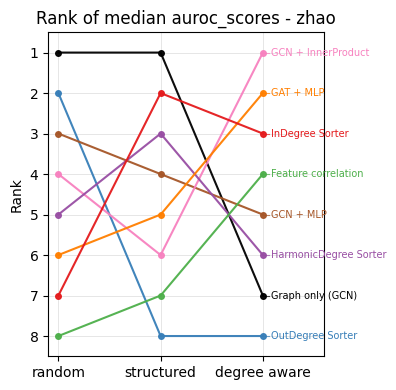

In [57]:
df_bump = long_df.copy()
sampling_order = ["random", "structured_tail", "degree_aware"]
display_names = {"random": "random", "structured_tail": "structured", "degree_aware": "degree aware"}
medians_df = df_bump.groupby(["sampling", "abbrev"], as_index=False)["score"].median().rename(columns={"score": "median_score"})
medians_df = medians_df[medians_df["sampling"].isin(sampling_order)]
pivot_df = medians_df.pivot(index="abbrev", columns="sampling", values="median_score")
cols_present = [s for s in sampling_order if s in pivot_df.columns]
pivot_df = pivot_df[cols_present].dropna(how="any")
ranks_df = pivot_df.rank(ascending=False, axis=0, method="min").astype(int)
first_sampling = cols_present[0]
ranks_df = ranks_df.sort_values(by=first_sampling)
fig, ax = plt.subplots(figsize=(4, 4))
x = np.arange(len(cols_present))
for abbrev, row in ranks_df.iterrows():
    y = row.values.astype(float)
    color = model_colors_abbrev.get(abbrev, "#cccccc")
    ax.plot(x, y, marker="o", color=color, linewidth=1.5, markersize=4, alpha=0.95)
last_sampling = cols_present[-1]
groups = {}
for abbrev, row in ranks_df.iterrows():
    y_last = float(row[last_sampling])
    groups.setdefault(y_last, []).append(abbrev)
offsets = {rank: (np.linspace(-0.2, 0.2, len(names)) if len(names) > 1 else np.array([0.0])) for rank, names in groups.items()}
for rank_value, names in groups.items():
    for idx, abbrev in enumerate(names):
        color = model_colors_abbrev.get(abbrev, "#666666")
        y_pt = rank_value
        y_text = rank_value + float(offsets[rank_value][idx])
        ax.plot([x[-1], x[-1] + 0.06], [y_pt, y_text], color=color, linewidth=0.8, alpha=0.7)
        ax.text(x[-1] + 0.08, y_text, abbrev, va="center", ha="left", fontsize=7, color=color)
ax.set_title(f"Rank of median {metric} - {dataset}")
ax.set_ylabel("Rank")
ax.set_xticks(x)
ax.set_xticklabels([display_names[s] for s in cols_present])
ax.set_xlim(-0.1, x[-1] + 0.6)
ymax = int(ranks_df.values.max())
ax.set_yticks(np.arange(1, ymax + 1))
ax.set_ylim(ymax + 0.5, 0.5)
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
ax.xaxis.grid(True, which="major", linestyle="-", linewidth=0.4, color="lightgrey", zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig("outputs/bump_chart_model_ranks.pdf", bbox_inches="tight")
plt.show()
plt.close()
